# Exercise 05

Montecarlo simulation of the 4d Ising model using the cluster algorithm.

A sample python code to do cluster updates of the d-dimensional Ising model.

In [1]:
## union-find routines

# returns index of cluster to which spin at index x belongs (x is an integer)
def find_cluster(cluster, x):
    while(x != cluster[x]):
        # compress path: set parent of x to its grandparent
        cluster[x] = cluster[cluster[x]];
        # climb tree
        x = cluster[x];
    return x

# connect clusters to which spins at x and y belong
def connect_clusters(cluster, cluster_size, x, y):
    x_cluster = find_cluster(cluster, x)
    y_cluster = find_cluster(cluster, y)
    # if not already connected, then connect them
    if (x_cluster != y_cluster):
        # connect smaller tree to root of larger tree
        if (cluster_size[x] < cluster_size[y]):
            cluster[x_cluster] = y_cluster;
            cluster_size[y_cluster] += cluster_size[x_cluster];
        else:
            cluster[y_cluster] = x_cluster;
            cluster_size[x_cluster] += cluster_size[y_cluster];

In [2]:
## d-dimensional lattice with periodic boundary conditions
import numpy as np

# shape is a tuple of lattice dimensions, e.g. (8,8,8,8) would be a 8^4 lattice
# ix is an integer index that refers to a site on this lattice
# mu is a dimension, starting at 0, e.g. could be 0,1,2 or 3 on an L^4 lattice
# returns index of neighbour to site ix in +mu direction
def iup(shape, ix, mu):
    # convert flat index ix to d-dimensional tuple of indices
    x_d = np.unravel_index(ix, shape)
    # convert to array, and add 1 to mu-component
    tmpx_d = np.array(x_d)
    tmpx_d[mu] += 1
    # convert back to tuple
    y_d = tuple(tmpx_d)
    # convert tuple back to flat index iy with pbcs (mode='wrap')
    iy = np.ravel_multi_index(y_d, shape, mode='wrap')
    return iy

In [3]:
## cluster update routine
import numpy as np

# spins is a 1d array containing all the spins
# shape is a tuple with the dimensions of the lattice, e.g. (4,4) would be a 2d 4x4 lattice
# beta is the lattice coupling
def cluster_update(spins, shape, beta):
    # make array of cluster values for each spin
    # initially each is its own cluster
    cluster = np.empty_like(spins)
    for i in range(0, cluster.size):
        cluster[i] = i
    # each cluster has initial size 1
    cluster_size = np.ones_like(cluster)

    # construct clusters
    # sum over all sites..
    for ix in range(0, spins.size):
        # ..and over all directions
        for mu in range(0, len(shape)):
            # find index of neighbouring site
            iy = iup(shape, ix, mu)
            # construct bond (or not) between sites
            if(spins[ix] == spins[iy]):
                if(np.random.uniform() > np.exp(-2.0*beta)):
                    connect_clusters(cluster, cluster_size, ix, iy)

    # make random spins for each cluster
    cluster_spins = 2 * np.random.randint(2, size=cluster.shape) - 1
            
    # assign cluster spins to sites
    for i in range(0, cluster.size):
        spins[i] = cluster_spins[find_cluster(cluster, i)]

In [4]:
## observables
import numpy as np

# returns energy normalised by the volume (number of sites)
def E(spins, shape):
    tmpE = 0
    for ix in range(0, spins.size):
        for mu in range(0, len(shape)):
            iy = iup(shape, ix, mu)
            tmpE += spins[ix] * spins[iy]
    return -tmpE / spins.size

# returns absolute magnetisation normalised by the volume (number of sites)
def M(spins):
    return np.fabs(np.sum(spins)/spins.size)

In [5]:
## routine to do a simulation and plot E & M
import matplotlib.pyplot as plt
import numpy as np

# shape is a tuple of lattice dimensions, eg (4,4,4,4) or (8,8)
# beta is a list or array of beta values to simulate
# n_therm is how many updates to discard for thermalisation
# n_updates is how many updates to then do with measurements
# plots resulting energy and magnetisation vs beta
def do_simulation(shape, beta_list, n_therm, n_updates):

    # randomly set all spins to either 1 or -1:
    spins = 2 * np.random.randint(2, size=np.prod(shape)) - 1

    # do simulation
    obs_beta = []
    for beta in beta_list:
        for i in range (0, n_therm):
            cluster_update(spins, shape, beta)
        m = []
        e = []
        for i in range (0, n_updates):
            cluster_update(spins, shape, beta)
            m.append(M(spins))
            e.append(E(spins, shape))
        m = np.array(m)
        e = np.array(e)
        obs_beta.append([beta, np.average(m), np.std(m)/np.sqrt(m.size), np.average(e), np.std(e)/np.sqrt(m.size)])
    obs_beta = np.array(obs_beta)
    
    # critical beta line for plots
    if(len(shape)==4):
        beta_critical = 0.1496947
    elif(len(shape)==2):
        beta_critical = 0.440687
    else:
        beta_critical = 0
    
    # plot energy
    plt.rcParams["figure.figsize"] = (20,10)
    plt.figure()
    plt.errorbar(obs_beta[:,0], obs_beta[:,3], yerr=obs_beta[:,4])
    plt.axvline(x=beta_critical, label="critical beta", linestyle='--', color="grey")
    plt.ylabel('E/N')
    plt.title(str(shape)+' lattice: Energy vs Beta')
    plt.show()
    
    # plot magnetisation
    plt.rcParams["figure.figsize"] = (20,10)
    plt.figure()
    plt.errorbar(obs_beta[:,0], obs_beta[:,1], yerr=obs_beta[:,2])
    plt.axvline(x=beta_critical, label="critical beta", linestyle='--', color="grey")
    plt.ylabel('|M|/N')
    plt.title(str(shape)+' lattice: Magnetisation vs Beta')
    plt.show()

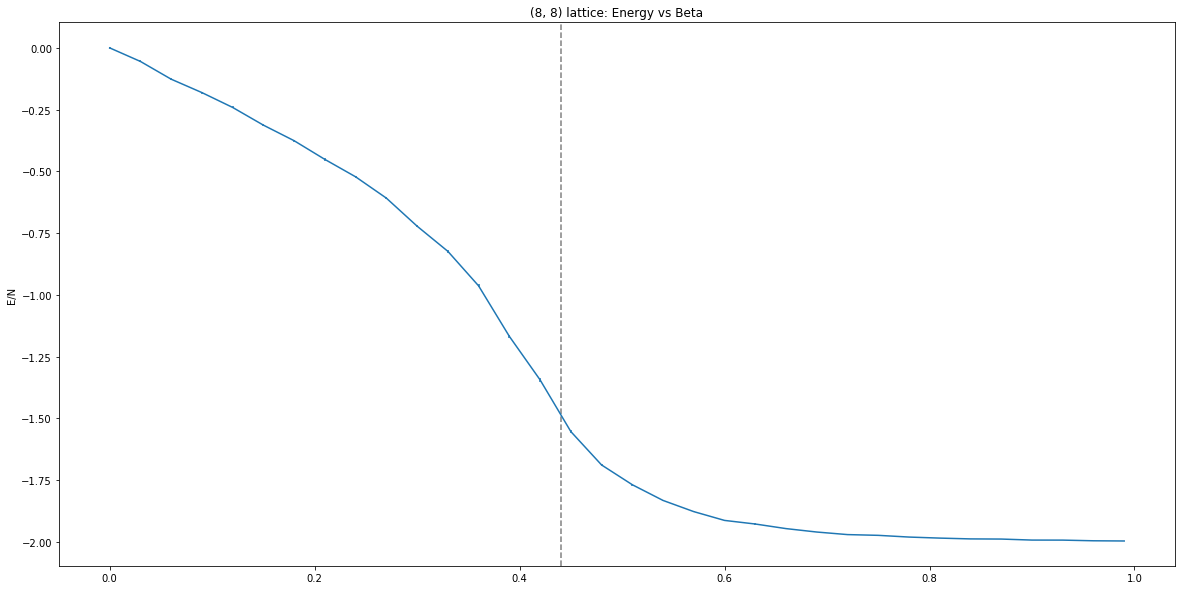

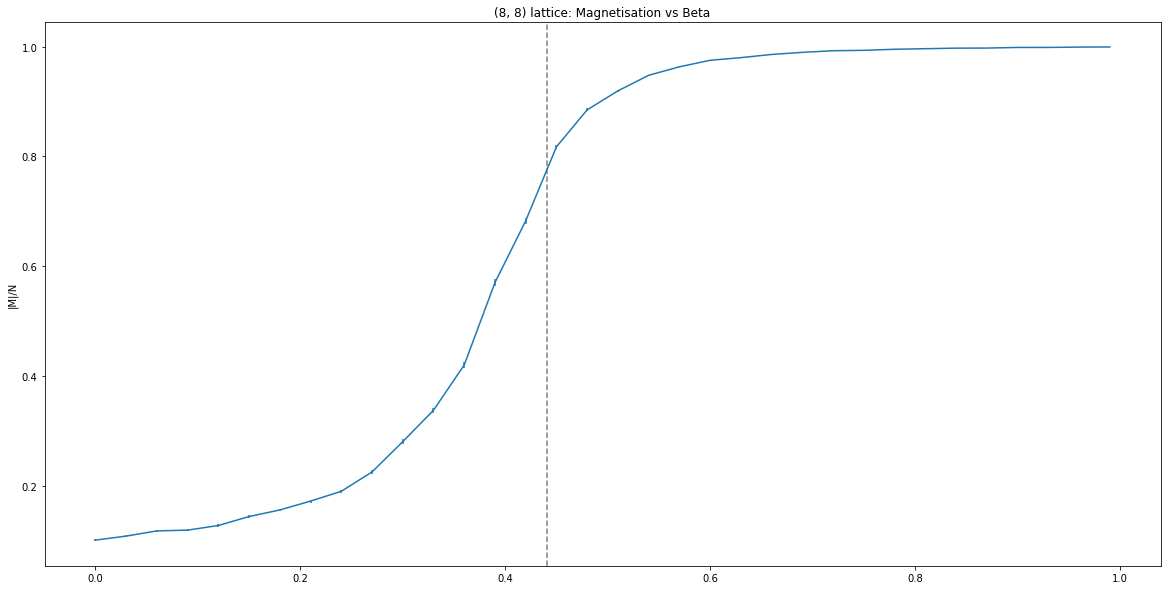

In [6]:
# simulate a 2d 8x8 lattice for a range of beta, 200 thermalisation updates, 2000 measurement updates
do_simulation((8,8), np.arange(0,1,0.03), 200, 2000)

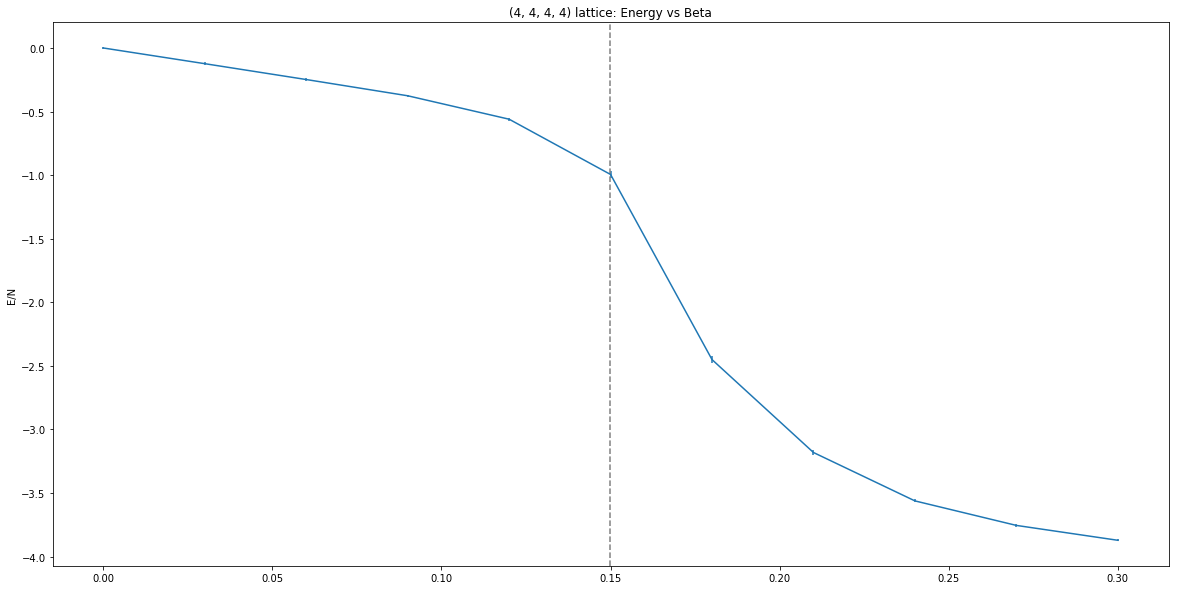

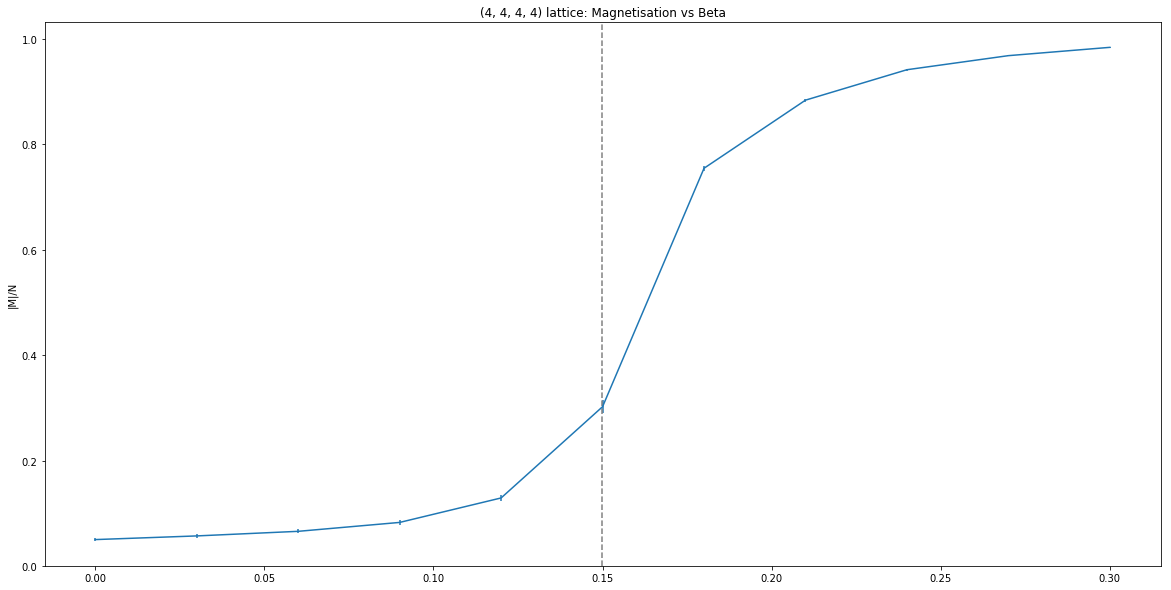

In [7]:
# simulate a 4d 4^4 lattice for a range of beta, 50 thermalisation updates, 200 measurement updates
do_simulation((4,4,4,4), np.arange(0,0.31,0.03), 50, 200)